In [19]:
!pip install peft

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
from collections import defaultdict
from collections import Counter
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import os
from pathlib import Path
from PIL import Image
import requests
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, Dataset
import itertools
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
from sklearn.metrics import confusion_matrix
from peft import LoraConfig, get_peft_model
from transformers import (
    DataCollator,
    CLIPProcessor, 
    CLIPModel, 
    TrainingArguments, 
    Trainer
)

In [21]:
def hf_clip_predict(model, processor, text_labels, images):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    text = [f"A photo of a {label}" for label in text_labels]
    inputs = processor(text=text, images=images, return_tensors="pt", padding=True).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    return probs

def get_image_paths_and_labels_from_df(df, data_dir):
    article_ids = df["article_id"].values
    image_paths = []
    labels = []
    
    for article_id in article_ids:
        image_path = f"{data_dir}/images/0{str(article_id)[:2]}/0{article_id}.jpg"
        # Check if the image file exists
        if os.path.exists(image_path):
            image_paths.append(image_path)
            # Add corresponding label only if the image exists
            labels.append(df[df["article_id"] == article_id])
        else:
            print(f"Image not found for article_id: {article_id}")
    
    return image_paths, labels

def get_image_paths_and_labels_ordered(df, data_dir):
    article_ids = df["article_id"].values
    image_paths = []
    labels = []
    for article_id in article_ids:
        image_path = f"{data_dir}/images/0{str(article_id)[:2]}/0{article_id}.jpg"
        if os.path.exists(image_path):
            image_paths.append(image_path)
            labels.append(df[df["article_id"] == article_id])
    
    return image_paths, labels

def get_image_paths_and_labels(df, data_dir):
    image_paths = []
    labels = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".jpg"):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)
                article_id = int(file.split(".")[0])
                labels.append(df[df["article_id"] == article_id])

    return image_paths, labels

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, processor=None):
        self.image_paths = image_paths
        self.processor = processor
        self.image_ids = []

        for image_path in self.image_paths:
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Image {image_path} not found.")
            else:
                image_id = int(image_path.split("/")[-1].split(".")[0])
                self.image_ids.append(image_id)
            

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.processor is not None:
            inputs = self.processor(images=image, return_tensors="pt", padding=True)
            image = inputs["pixel_values"][0]
        return image, self.image_ids[idx]

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [23]:
text_path = '/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv'
articles = pd.read_csv(text_path)
print(articles.shape) # 100k data points
articles.head(1)

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [24]:
# map from article_id to df index
article_id_to_idx = {article_id: idx for idx, article_id in enumerate(articles["article_id"])}

# get all classes of the dataframe
class_names = articles.columns.tolist()
label_names = dict()
label_names_to_idx = dict()
for class_name in class_names:
    label_names[class_name] = articles[class_name].unique()
    label_names_to_idx[class_name] = {label_name: idx for idx, label_name in enumerate(label_names[class_name])}

article_ids = label_names["article_id"]
selected_class_names = ["product_group_name", "product_type_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]

In [25]:
# get label names in product group name with less than 10 samples
product_group_name_cnts = articles["product_group_name"].value_counts()
removed_label_names = product_group_name_cnts[product_group_name_cnts < 10]

# remove data with the removed label name
removed_label_idxs = articles[articles["product_group_name"].isin(removed_label_names.index)].index
articles = articles.drop(removed_label_idxs)

In [26]:
data_dir = "/kaggle/input/h-and-m-personalized-fashion-recommendations"
image_paths, labels = get_image_paths_and_labels_from_df(articles, data_dir)
print(f"Number of images: {len(image_paths)}")

Image not found for article_id: 174057028
Image not found for article_id: 179208001
Image not found for article_id: 212042043
Image not found for article_id: 212042066
Image not found for article_id: 212629004
Image not found for article_id: 215324023
Image not found for article_id: 216961011
Image not found for article_id: 218354021
Image not found for article_id: 241602023
Image not found for article_id: 268305006
Image not found for article_id: 272591001
Image not found for article_id: 324963030
Image not found for article_id: 348657006
Image not found for article_id: 357792006
Image not found for article_id: 364409037
Image not found for article_id: 369423002
Image not found for article_id: 369423004
Image not found for article_id: 388916001
Image not found for article_id: 395864048
Image not found for article_id: 396135047
Image not found for article_id: 396135048
Image not found for article_id: 396690010
Image not found for article_id: 397376010
Image not found for article_id: 39

现在的数据集是按照prod_name直接来随机分的，训练：验证 = 8:2， 测试集为200个。同一个prod_name应该只会在三个数据集中的一个，满足fredrik的要求（待验证？）

In [30]:
prod_name_to_images = defaultdict(list)
for idx, label_df in enumerate(labels):
    prod_name = label_df['prod_name'].values[0]  # Extract scalar value
    prod_name_to_images[prod_name].append(idx)  # Store the index of the image

all_prod_names = list(prod_name_to_images.keys())
random.seed(42)  # For reproducibility
random.shuffle(all_prod_names)

#Allocate 'prod_name's to the test set until we have at least 200 images
test_prod_names = []
test_image_indices = []
total_test_images = 0
for prod_name in all_prod_names:
    indices = prod_name_to_images[prod_name]
    if total_test_images + len(indices) > 200:
        # Adjust to get exactly 200 images
        remaining_slots = 200 - total_test_images
        test_image_indices.extend(indices[:remaining_slots])
        total_test_images += remaining_slots
        break
    else:
        test_prod_names.append(prod_name)
        test_image_indices.extend(indices)
        total_test_images += len(indices)
    if total_test_images == 200:
        break

# Remove selected 'prod_name's from the list of all 'prod_name's
remaining_prod_names = [pn for pn in all_prod_names if pn not in test_prod_names]

# 8/2 split
num_train = int(0.8 * len(remaining_prod_names))
train_prod_names = remaining_prod_names[:num_train]
val_prod_names = remaining_prod_names[num_train:]

train_image_indices = []
for prod_name in train_prod_names:
    train_image_indices.extend(prod_name_to_images[prod_name])

val_image_indices = []
for prod_name in val_prod_names:
    val_image_indices.extend(prod_name_to_images[prod_name])

train_image_paths = [image_paths[idx] for idx in train_image_indices]
train_labels = [labels[idx] for idx in train_image_indices]

val_image_paths = [image_paths[idx] for idx in val_image_indices]
val_labels = [labels[idx] for idx in val_image_indices]

test_image_paths = [image_paths[idx] for idx in test_image_indices]
test_labels = [labels[idx] for idx in test_image_indices]

# #256 for test
# train_image_paths = train_image_paths[:256]
# train_labels = train_labels[:256]

# val_image_paths = val_image_paths[:256]
# val_labels = val_labels[:256]

print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")
print(f"Number of test images: {len(test_image_paths)}")

Number of training images: 256
Number of validation images: 256
Number of test images: 200


In [31]:
train_dataset = ImageDataset(train_image_paths, processor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

val_dataset = ImageDataset(val_image_paths, processor)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

test_dataset = ImageDataset(test_image_paths, processor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

In [32]:
# Define LoRA configuration
lora_config = LoraConfig(
    r=8,                  # Low-rank dimension (adjustable)
    lora_alpha=32,          # Scaling factor (adjustable)
    target_modules=["q_proj", "v_proj", "k_proj"],  # Specify which layers to apply LoRA to
    lora_dropout=0.05,       # Dropout rate (optional)
    bias="none",            # Whether to include biases ("none", "all", "lora_only")
    task_type="classification"  # Task type ("classification" or "regression")
)

# Apply LoRA to the CLIP model
model = get_peft_model(model, lora_config)

定义confusion matrix画几个类

In [37]:
N = 5  # Number of top classes to include in the confusion matrix

In [38]:
def plot_confusion_matrix(cm, class_labels, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

In [39]:
def validate(model, val_dataloader, criteria, device, tokenized_texts, selected_class_names, epoch):
    model.eval()
    total_loss = 0.0
    total_correct = {class_name: 0 for class_name in selected_class_names}
    total_samples = 0

    # Initialize containers for confusion matrices
    all_true_labels = {class_name: [] for class_name in selected_class_names}
    all_preds = {class_name: [] for class_name in selected_class_names}

    with torch.no_grad():
        for images, image_ids in tqdm(val_dataloader):
            images = images.to(device)
            batch_size = images.size(0)

            # Get true labels for all classes
            true_labels = {}
            for class_name in selected_class_names:
                labels = [
                    label_names_to_idx[class_name][
                        articles.loc[article_id_to_idx[image_id.item()], class_name]
                    ] for image_id in image_ids
                ]
                true_labels[class_name] = torch.tensor(labels).to(device)

            # Compute image embeddings
            image_features = model.get_image_features(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            loss = 0.0  # Reset loss for the batch

            # Iterate over each class
            for class_name in selected_class_names:
                # Move tokenized text inputs to device
                inputs = tokenized_texts[class_name]
                inputs = {k: v.to(device) for k, v in inputs.items()}

                # Compute text embeddings
                text_features = model.get_text_features(**inputs)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)

                # Compute similarity logits
                logits_per_image = image_features @ text_features.T  # Shape: [batch_size, num_labels]

                # Compute loss for this class
                class_loss = criteria(logits_per_image, true_labels[class_name])
                loss += class_loss  # Sum losses from all classes

                # Predictions and accuracy
                _, preds = torch.max(logits_per_image, dim=1)
                total_correct[class_name] += (preds == true_labels[class_name]).sum().item()

                # Collect true labels and predictions for confusion matrix
                all_true_labels[class_name].extend(true_labels[class_name].cpu().numpy())
                all_preds[class_name].extend(preds.cpu().numpy())

            total_loss += loss.item() * batch_size
            total_samples += batch_size

    avg_loss = total_loss / total_samples
    accuracy = {class_name: total_correct[class_name] / total_samples for class_name in selected_class_names}

    # Compute and display confusion matrices for validation
    for class_name in selected_class_names:
        true_labels_np = np.array(all_true_labels[class_name])
        preds_np = np.array(all_preds[class_name])

        # Compute the frequency of each class in true labels
        label_counts = Counter(true_labels_np)
        # Get the top N classes
        top_N_classes = [label for label, _ in label_counts.most_common(N)]
        top_N_set = set(top_N_classes)

        # Create a mapping from old labels to new indices
        label_to_new_index = {label: idx for idx, label in enumerate(top_N_classes)}
        other_label_index = N  # Index for 'Other' category

        # Remap labels
        remapped_true_labels = np.array([
            label_to_new_index.get(label, other_label_index) for label in true_labels_np
        ])
        remapped_preds = np.array([
            label_to_new_index.get(label, other_label_index) for label in preds_np
        ])

        # Update class labels for the confusion matrix
        class_labels_for_cm = [label_names[class_name][label] for label in top_N_classes] + ['Other']

        # Compute confusion matrix
        cm = confusion_matrix(
            remapped_true_labels,
            remapped_preds,
            labels=list(range(N + 1))
        )

        # Plot confusion matrix
        plot_confusion_matrix(
            cm,
            class_labels_for_cm,
            title=f'Validation Confusion Matrix for {class_name} (Epoch {epoch+1})'
        )

    return avg_loss, accuracy

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/2], Loss: 36.3615
Accuracy for product_group_name: 0.3359
Accuracy for product_type_name: 0.4062
Accuracy for graphical_appearance_name: 0.0664
Accuracy for colour_group_name: 0.3047
Accuracy for perceived_colour_value_name: 0.1406
Accuracy for perceived_colour_master_name: 0.6016
Accuracy for department_name: 0.0898
Accuracy for index_name: 0.3047
Accuracy for index_group_name: 0.4492
Accuracy for section_name: 0.1016
Accuracy for garment_group_name: 0.3320


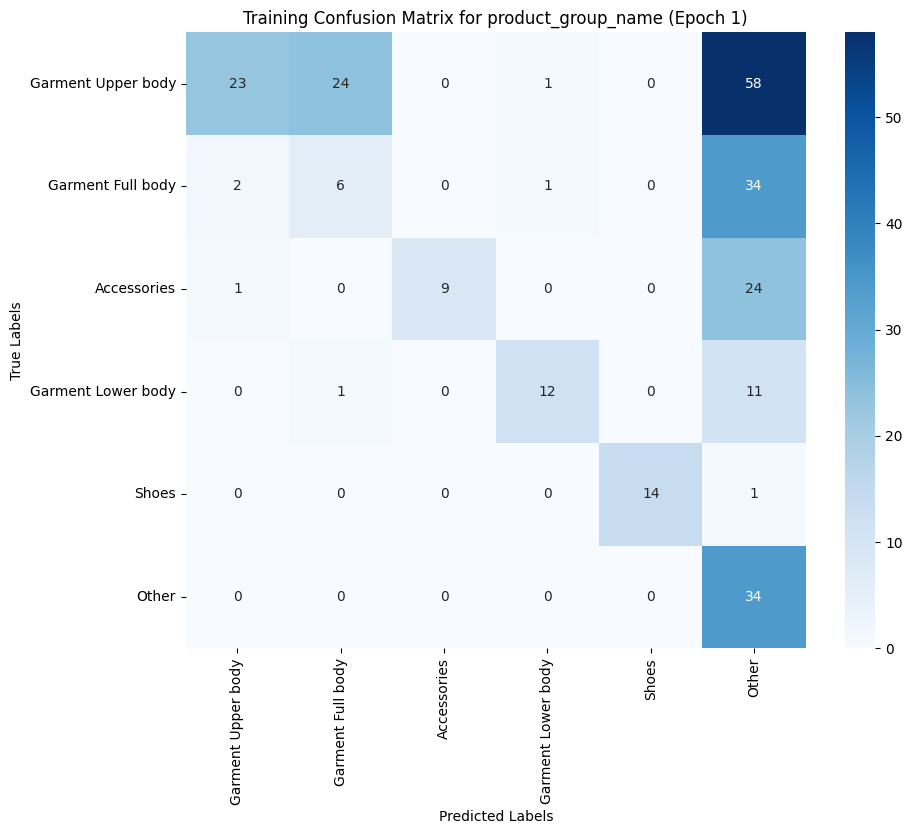

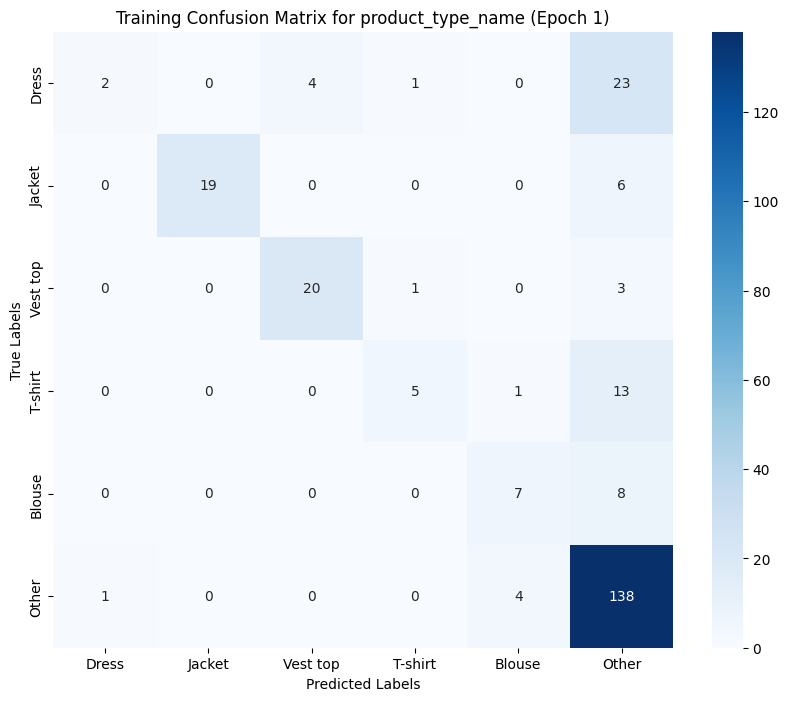

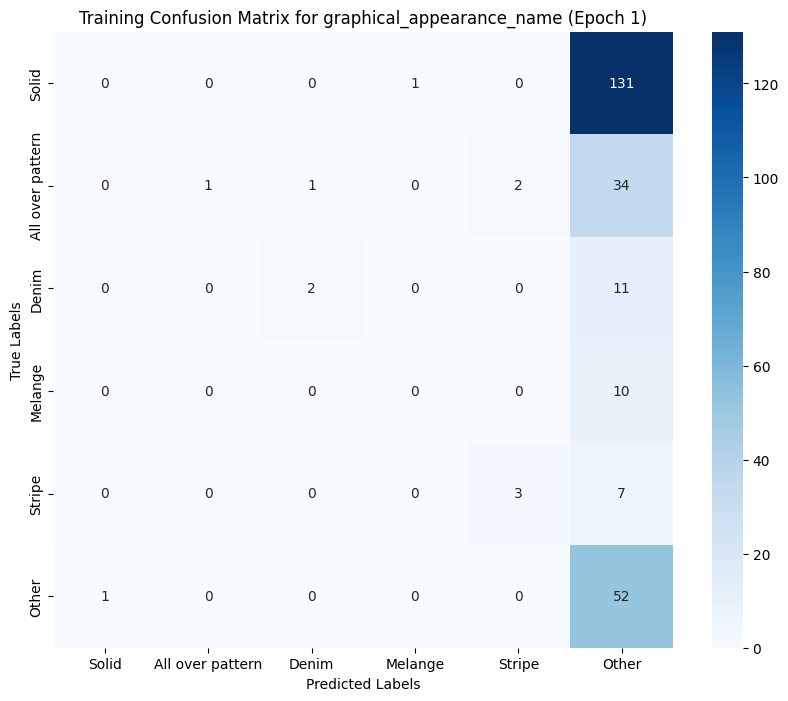

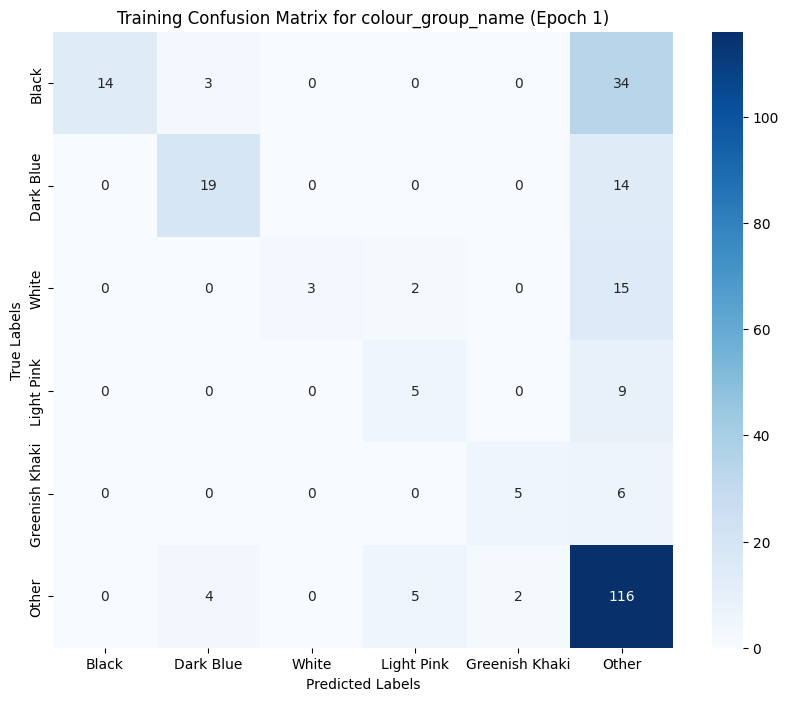

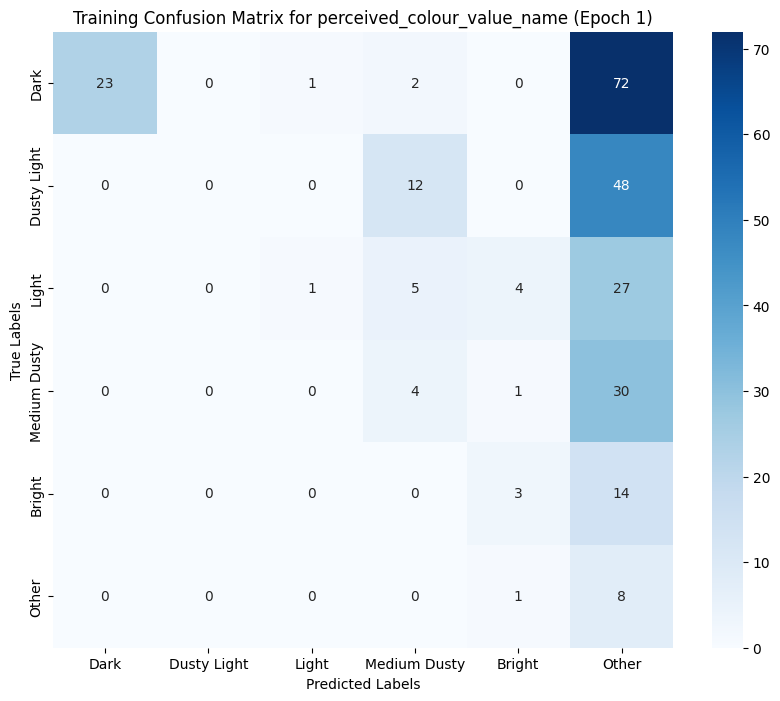

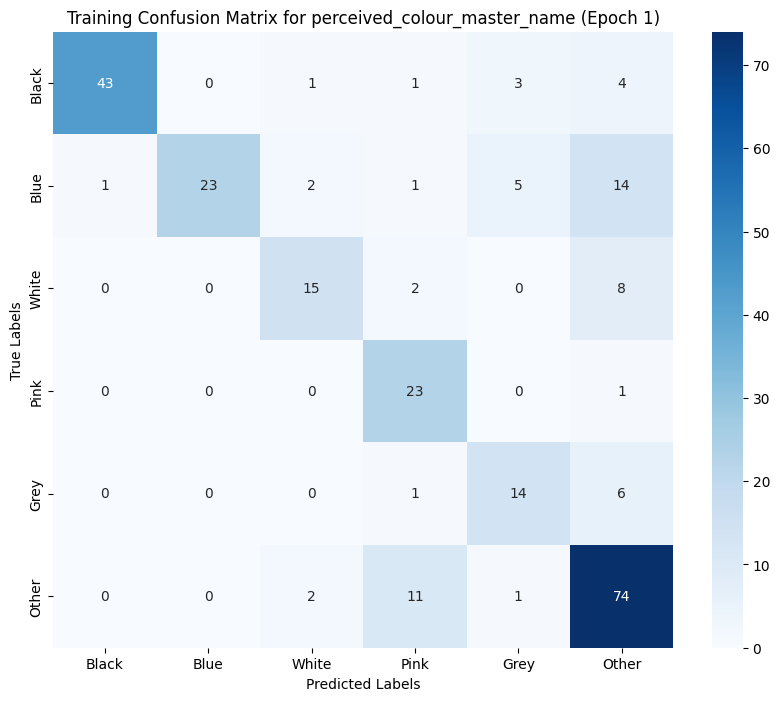

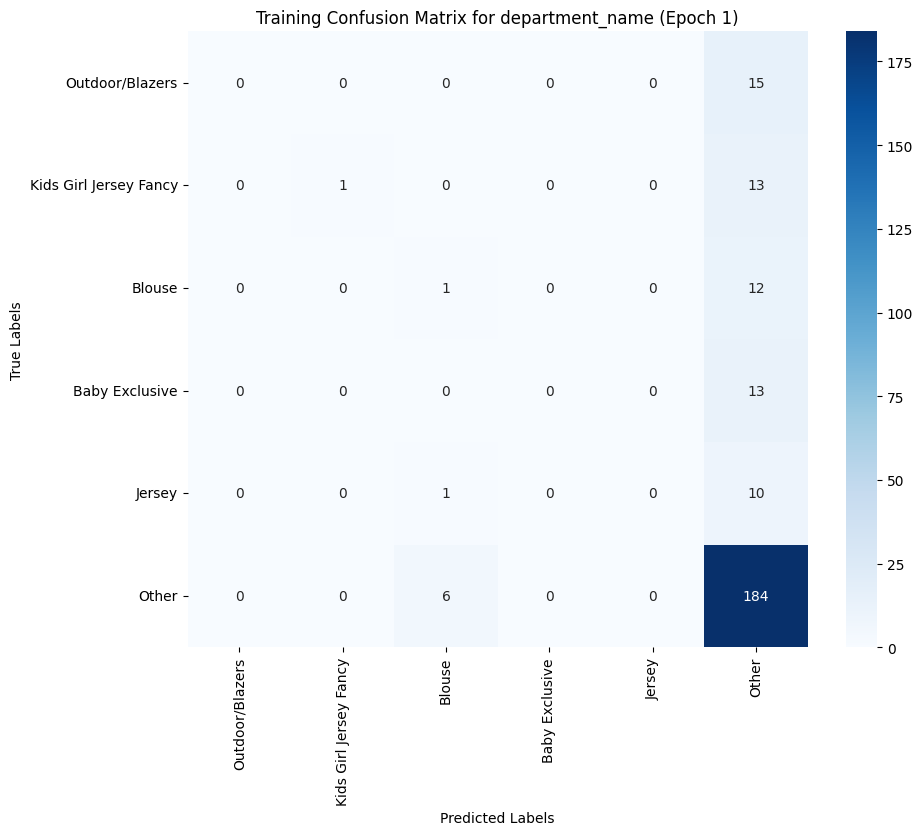

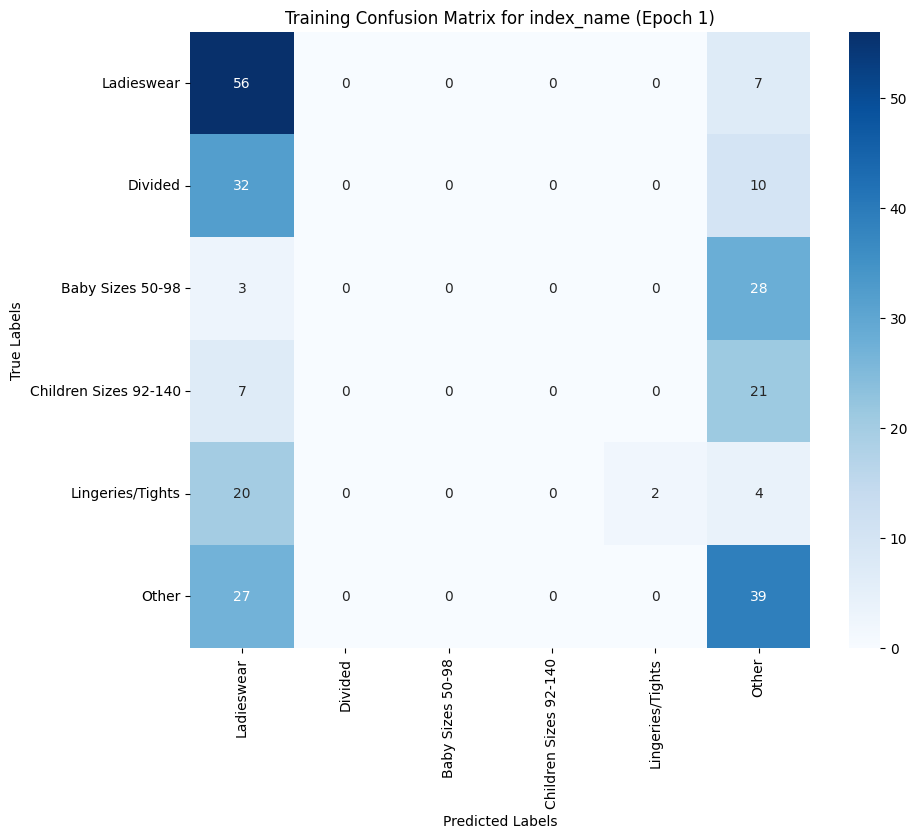

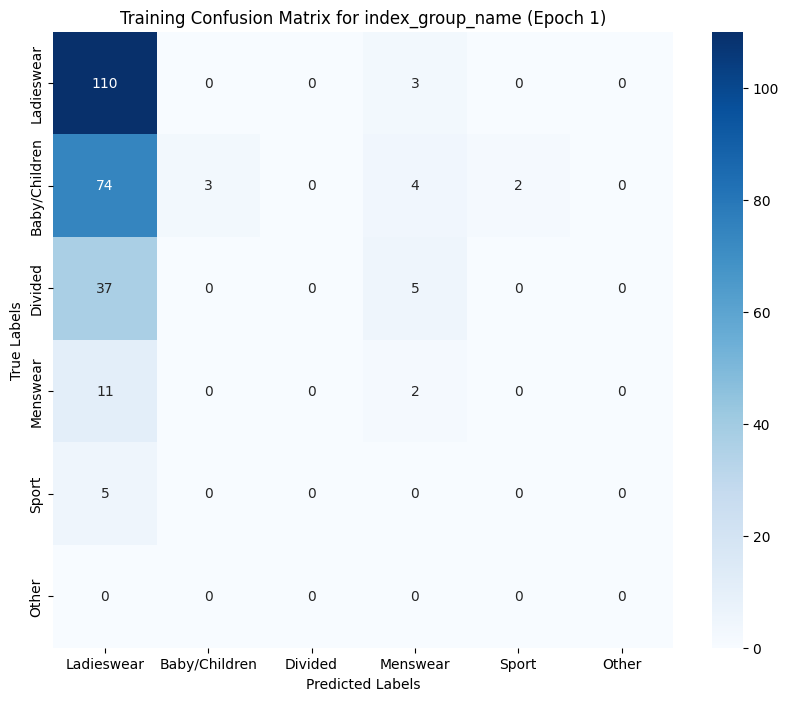

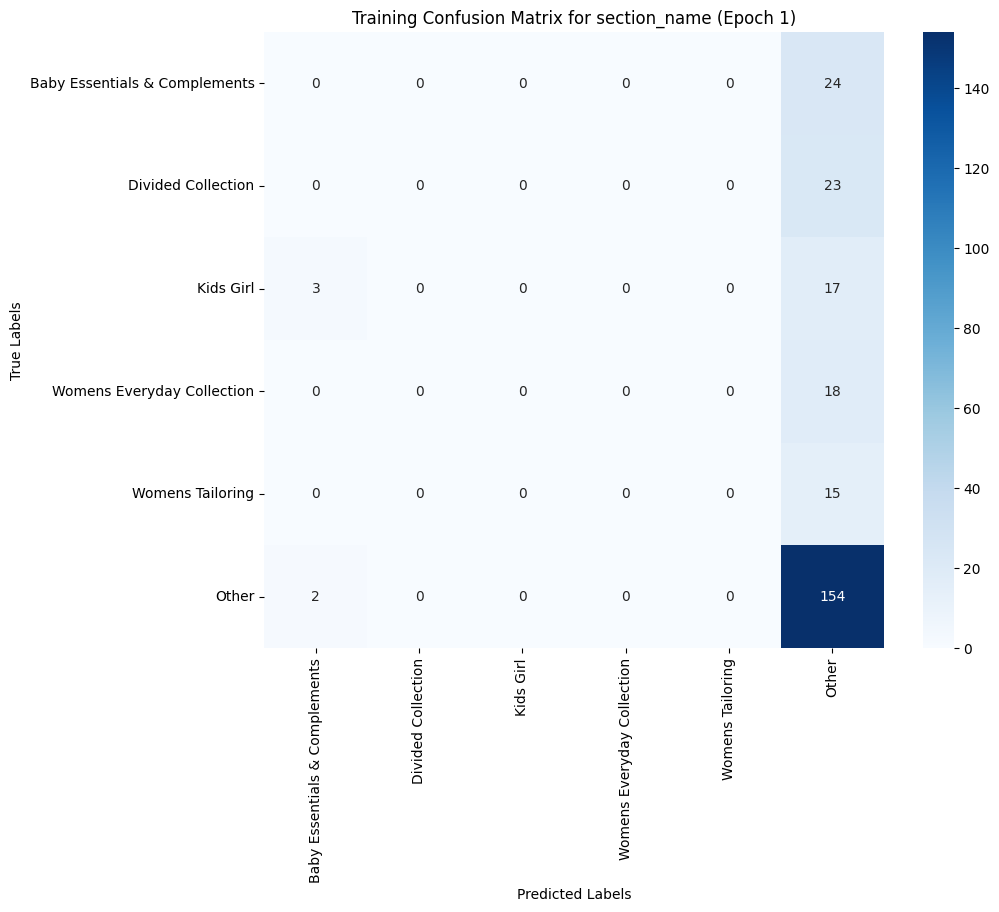

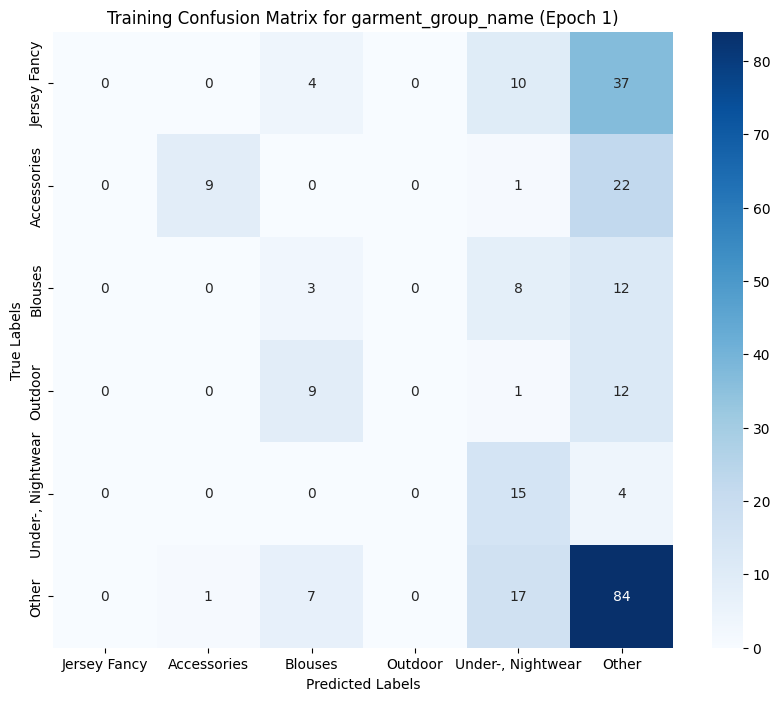

  0%|          | 0/1 [00:00<?, ?it/s]

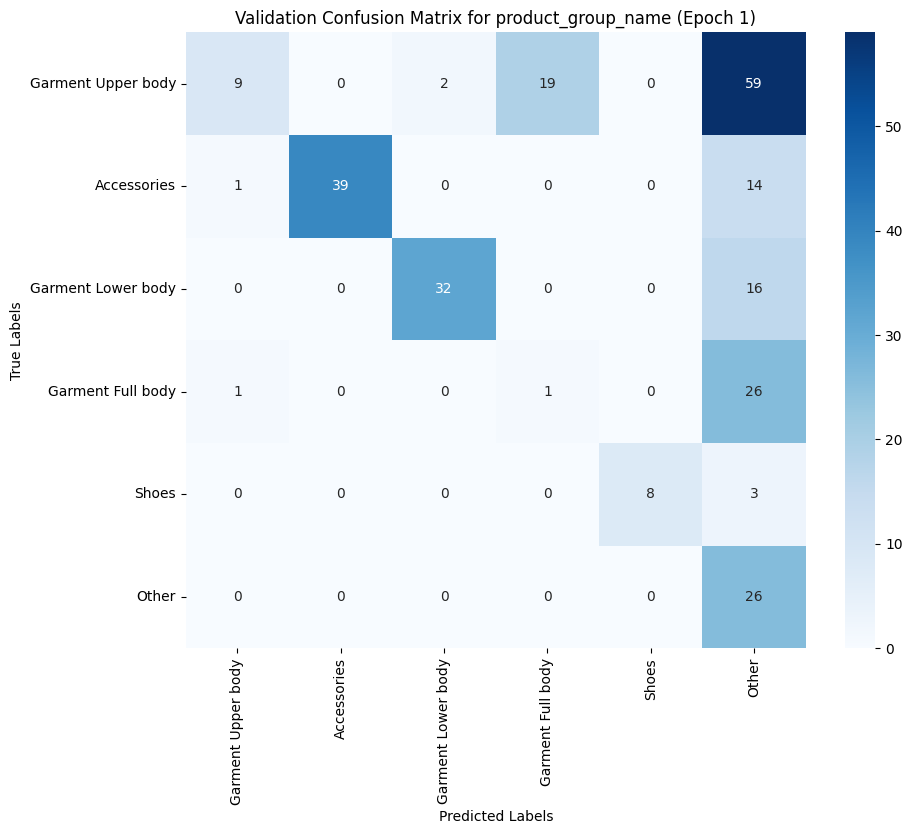

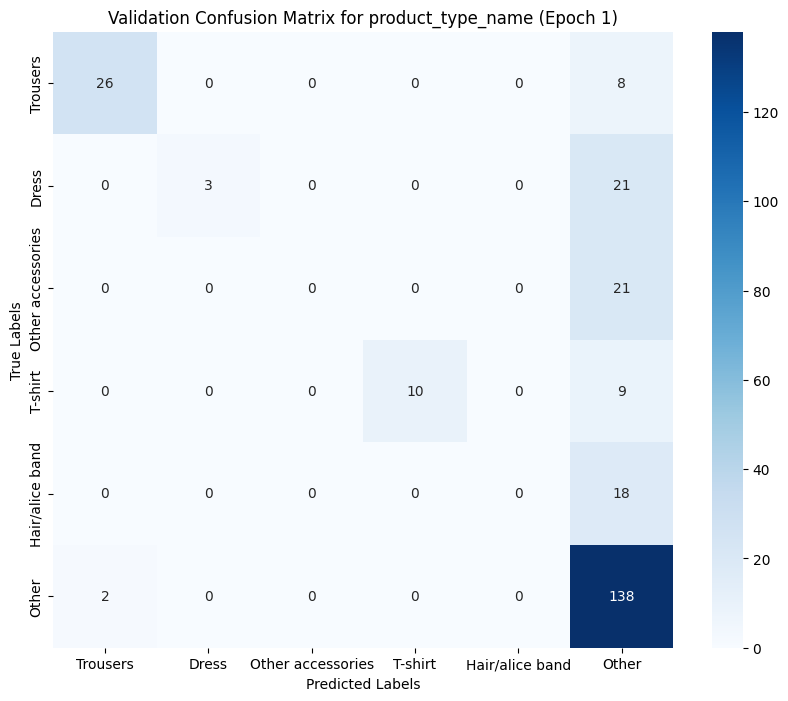

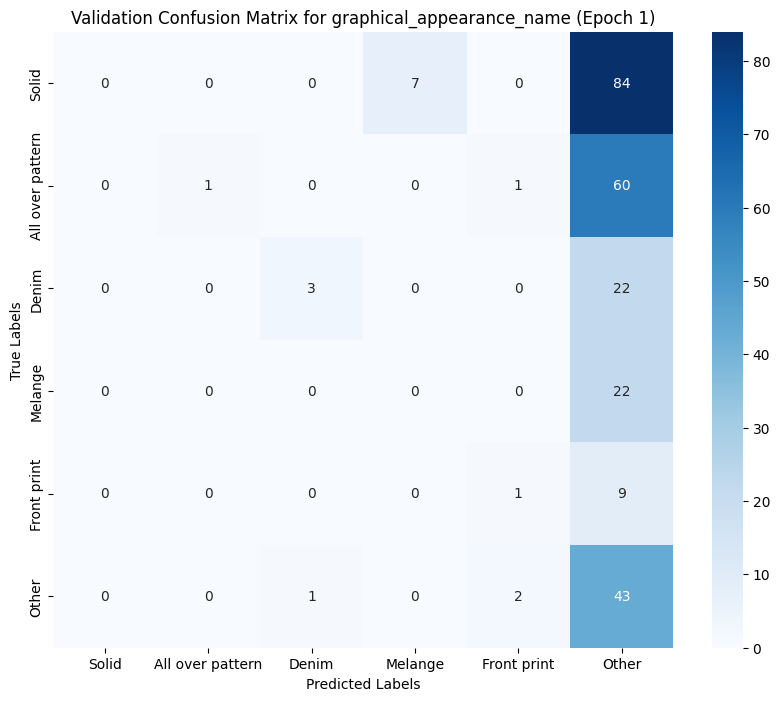

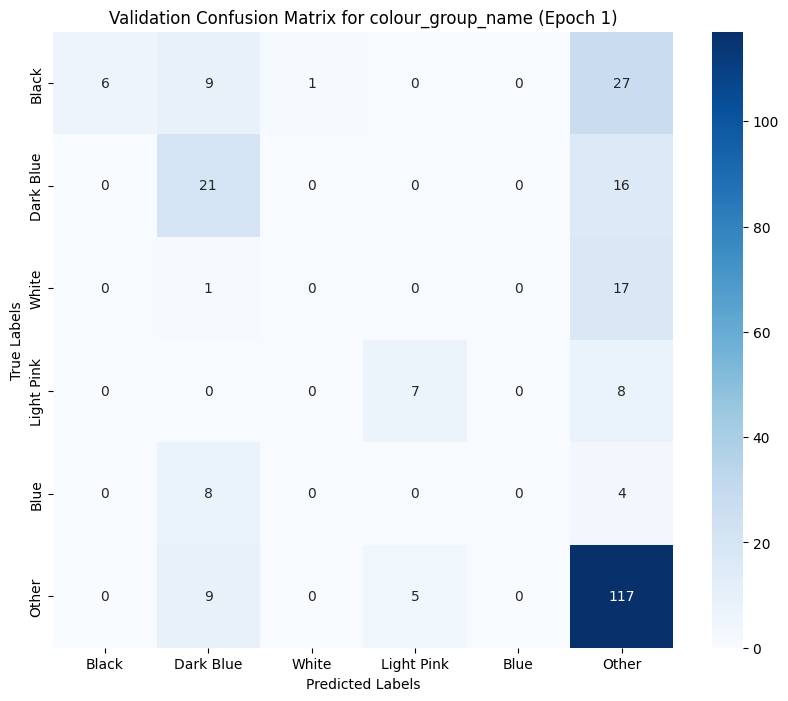

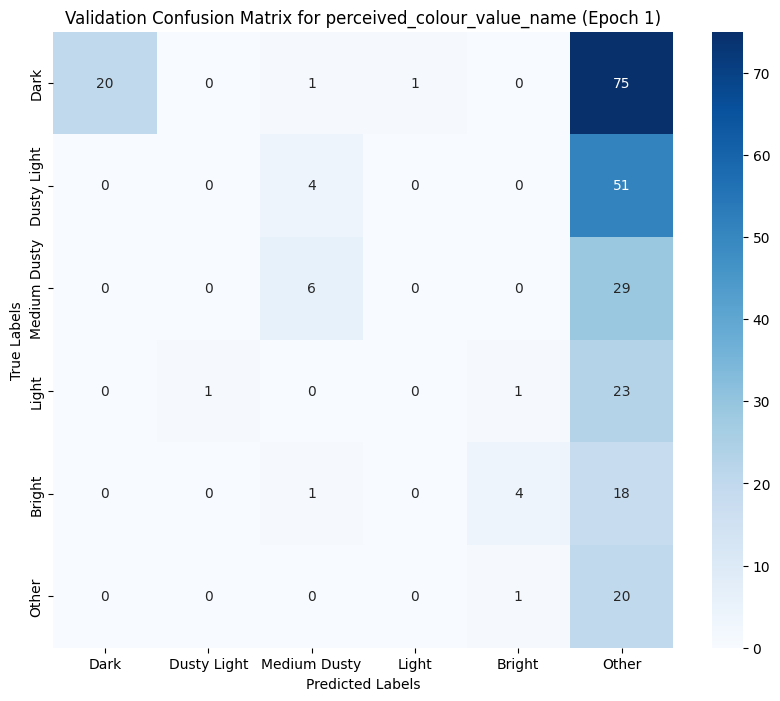

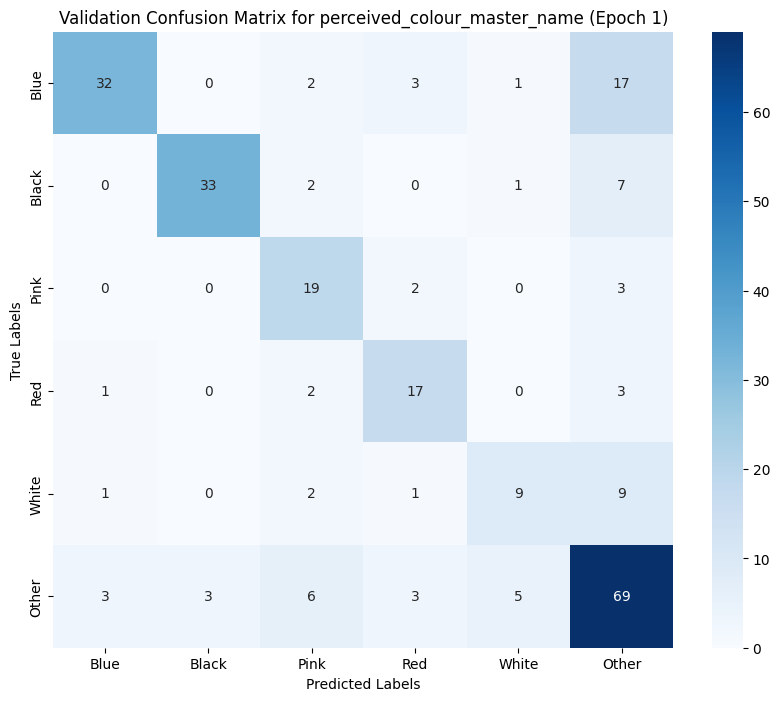

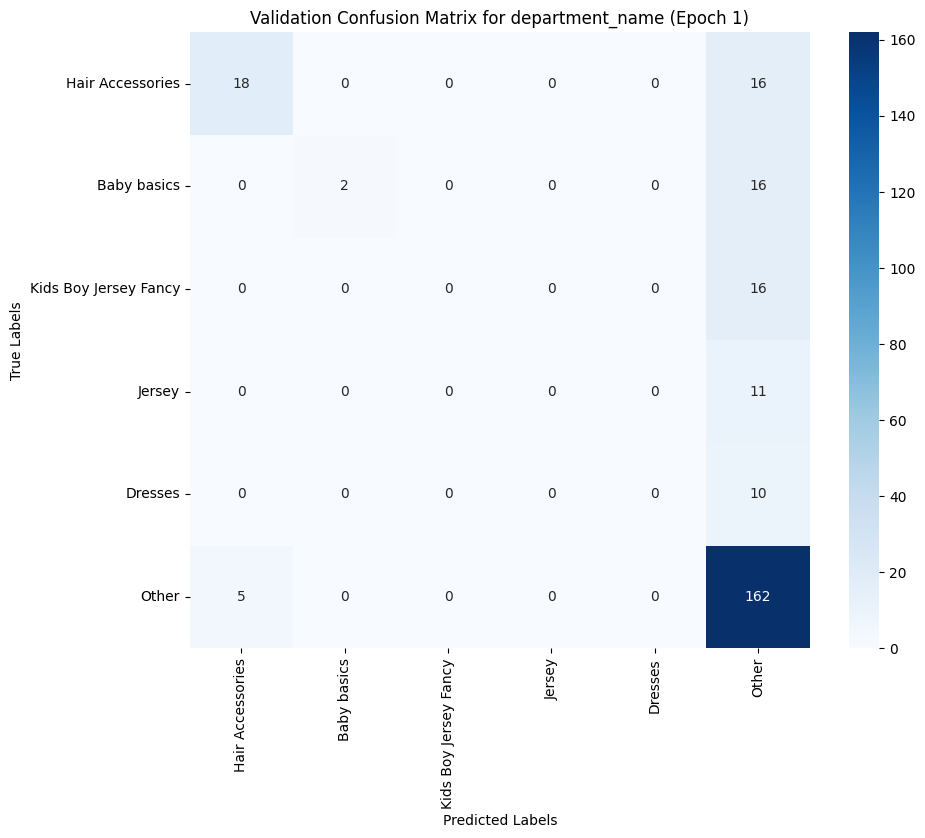

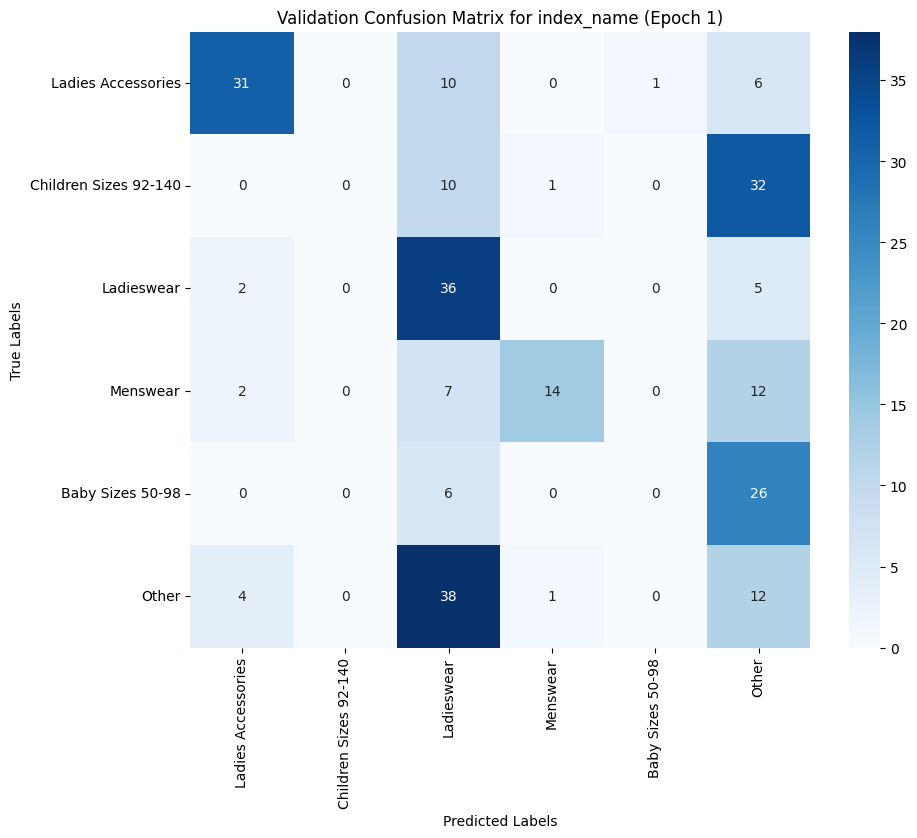

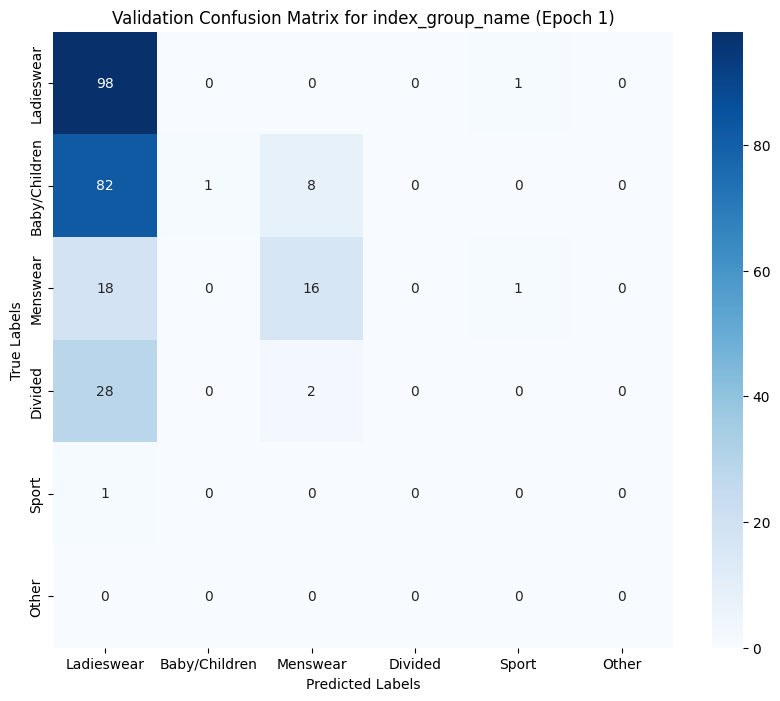

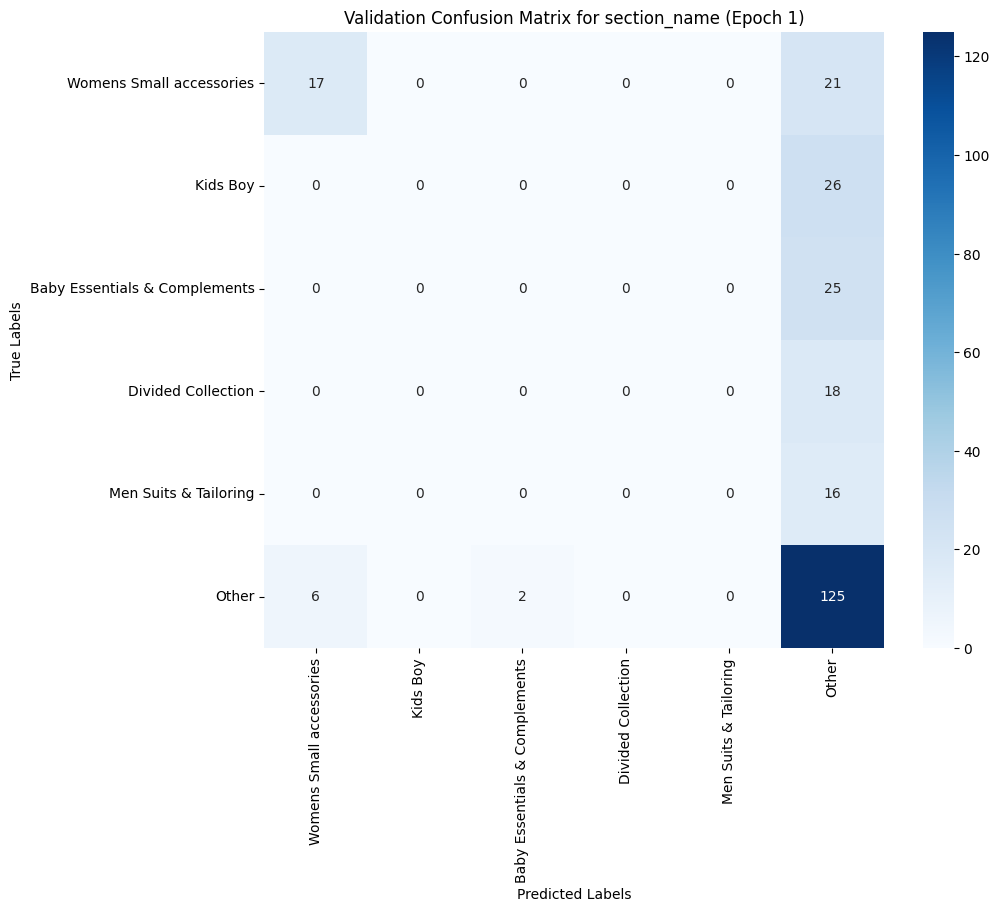

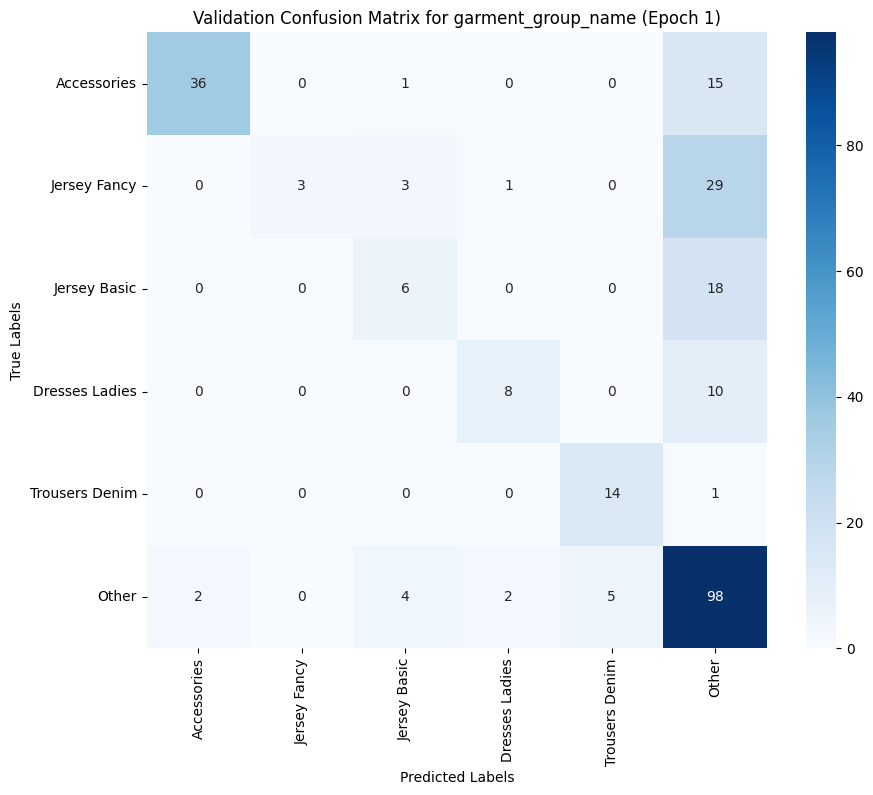

Validation Loss: 36.3483
Validation Accuracy for product_group_name: 0.4102
Validation Accuracy for product_type_name: 0.3867
Validation Accuracy for graphical_appearance_name: 0.0430
Validation Accuracy for colour_group_name: 0.2461
Validation Accuracy for perceived_colour_value_name: 0.1758
Validation Accuracy for perceived_colour_master_name: 0.5898
Validation Accuracy for department_name: 0.1133
Validation Accuracy for index_name: 0.3359
Validation Accuracy for index_group_name: 0.4492
Validation Accuracy for section_name: 0.1250
Validation Accuracy for garment_group_name: 0.4727


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [42]:
num_epochs = 2  # Adjust as needed
criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

model.to(device)

# Tokenize text inputs for all labels in all classes outside the batch loop
tokenized_texts = {}
for class_name in selected_class_names:
    labels = label_names[class_name]
    texts = [f"A photo of a {label}" for label in labels]
    tokenized_texts[class_name] = processor(
        text=texts,
        return_tensors="pt",
        padding=True
    )

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_correct = {class_name: 0 for class_name in selected_class_names}
    total_samples = 0
    
    # Initialize containers for confusion matrices
    all_true_labels = {class_name: [] for class_name in selected_class_names}
    all_preds = {class_name: [] for class_name in selected_class_names}

    for images, image_ids in tqdm(train_dataloader):
        images = images.to(device)
        batch_size = images.size(0)

        # Get true labels for all classes
        true_labels = {}
        for class_name in selected_class_names:
            labels = [
                label_names_to_idx[class_name][
                    articles.loc[article_id_to_idx[image_id.item()], class_name]
                ] for image_id in image_ids
            ]
            true_labels[class_name] = torch.tensor(labels).to(device)

        # Forward pass: compute image embeddings
        image_features = model.get_image_features(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        loss = 0.0  # Reset loss for the batch

        # Iterate over each class
        for class_name in selected_class_names:
            # Move tokenized text inputs to device
            inputs = tokenized_texts[class_name]
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Compute text embeddings
            text_features = model.get_text_features(**inputs)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # Compute similarity logits
            logits_per_image = image_features @ text_features.T  # Shape: [batch_size, num_labels]

            # Compute loss for this class
            class_loss = criteria(logits_per_image, true_labels[class_name])
            loss += class_loss  # Sum losses from all classes

            # Predictions and accuracy
            _, preds = torch.max(logits_per_image, dim=1)
            total_correct[class_name] += (preds == true_labels[class_name]).sum().item()
            
            # Collect true labels and predictions for confusion matrix
            all_true_labels[class_name].extend(true_labels[class_name].cpu().numpy())
            all_preds[class_name].extend(preds.cpu().numpy())

        total_loss += loss.item() * batch_size
        total_samples += batch_size

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = {class_name: total_correct[class_name] / total_samples for class_name in selected_class_names}
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    for class_name in selected_class_names:
        print(f"Accuracy for {class_name}: {accuracy[class_name]:.4f}")
    
    # Compute and display confusion matrices for training
    for class_name in selected_class_names:
        true_labels_np = np.array(all_true_labels[class_name])
        preds_np = np.array(all_preds[class_name])

        # Compute the frequency of each class in true labels
        label_counts = Counter(true_labels_np)
        # Get the top N classes
        top_N_classes = [label for label, _ in label_counts.most_common(N)]
        top_N_set = set(top_N_classes)

        # Create a mapping from old labels to new indices
        label_to_new_index = {label: idx for idx, label in enumerate(top_N_classes)}
        other_label_index = N  # Index for 'Other' category

        # Remap labels
        remapped_true_labels = np.array([
            label_to_new_index.get(label, other_label_index) for label in true_labels_np
        ])
        remapped_preds = np.array([
            label_to_new_index.get(label, other_label_index) for label in preds_np
        ])

        # Update class labels for the confusion matrix
        class_labels_for_cm = [label_names[class_name][label] for label in top_N_classes] + ['Other']

        # Compute confusion matrix
        cm = confusion_matrix(
            remapped_true_labels,
            remapped_preds,
            labels=list(range(N + 1))
        )

        # Plot confusion matrix
        plot_confusion_matrix(
            cm,
            class_labels_for_cm,
            title=f'Training Confusion Matrix for {class_name} (Epoch {epoch+1})'
        )

    # Validate after each epoch
    val_loss, val_accuracy = validate(model, val_dataloader, criteria, device, tokenized_texts, selected_class_names, epoch)
    print(f"Validation Loss: {val_loss:.4f}")
    for class_name in selected_class_names:
        print(f"Validation Accuracy for {class_name}: {val_accuracy[class_name]:.4f}")

In [ ]:
model_save_path = 'model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


In [ ]:
test_loss, test_accuracy = validate(model, test_dataloader, criteria, device, text_inputs, selected_class_names, 0)
print(f"Test Loss: {test_loss:.4f}")
for class_name in selected_class_names:
    print(f"Test Accuracy for {class_name}: {test_accuracy[class_name]:.4f}")